In [1]:
from jaad_data import JAAD
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy
import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image
from torchvision import transforms
import os


In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:


# Load the JAAD dataset
jaad = JAAD(data_path='../JAAD')
#jaad.generate_database()
#jaad.get_data_stats()


data_opts = {
    'sample_type': 'beh'
}
seq_train = jaad.generate_data_trajectory_sequence('train', **data_opts)  
seq_test = jaad.generate_data_trajectory_sequence('test', **data_opts)


---------------------------------------------------------
Generating action sequence data
fstride: 1
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad
jaad database loaded from c:\Users\Filippo\Documents\VSCode\Pedestrian_Intention\JAAD\data_cache\jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: train
Number of pedestrians: 324 
Total number of samples: 304 
---------------------------------------------------------
Generating action sequence data
fstride: 1
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen

In [ ]:
input_image = Image.open("C:\\Users\\Filippo\\Documents\\VSCode\\Pedestrian_Intention\\JAAD\\images\\video_0001\\00000.png")
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#  # move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda') 

# with torch.no_grad():
#     output = model(input_batch)['out'][0]
# output_predictions = output.argmax(0) 

In [ ]:
# Define the transformation
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_and_preprocess_image(image_path):
    try:
        input_image = Image.open(image_path).convert("RGB")
        input_tensor = preprocess(input_image)
        return input_tensor
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_images_in_directory(root_directory):
    image_tensors = []
    for root, _, files in os.walk(root_directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image_tensor = load_and_preprocess_image(image_path)
                if image_tensor is not None:
                    image_tensors.append(image_tensor)
    return image_tensors

# Example usage
#root_directory = "C:\\Users\\Filippo\\Documents\\VSCode\\Pedestrian_Intention\\JAAD\\images"  # Replace with your root directory path
root_directory ="C:\\Users\\Filippo\\Documents\\VSCode\\Pedestrian_Intention\\JAAD\\ciao"
# Load and preprocess all images
image_tensors = process_images_in_directory(root_directory)

# # Example processing with a model (assuming `model` is defined)
# if image_tensors:
#     input_batch = torch.stack(image_tensors)  # Create a batch from image tensors
#     if torch.cuda.is_available():
#         input_batch = input_batch.to('cuda')
#         model.to('cuda')

#     with torch.no_grad():
#         output = model(input_batch)['out']
#     output_predictions = [output_frame.argmax(0) for output_frame in output]
#     # Do something with `output_predictions`
# else:
#     print("No images found or processed.")

In [ ]:
print(image_tensors)

In [ ]:
# unnormalize = transforms.Normalize(
#            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#            std=[1/0.229, 1/0.224, 1/0.225]
# )
# img = unnormalize(input_tensor)
# img = img.permute(1, 2, 0).numpy()
# plt.imshow(img)
# plt.title(f"Transformed image: {image_path}")
# plt.show()

In [14]:
# Carica il modello DeepLab preaddestrato
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Definisci le trasformazioni necessarie
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
def get_semantic_mask(image_path, model, preprocess):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Crea un mini-batch

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    return output_predictions.cpu().numpy()

# Visualizza la maschera semantica
def visualize_mask(image_path, mask):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='jet')
    plt.title("Semantic Mask")
    plt.show()

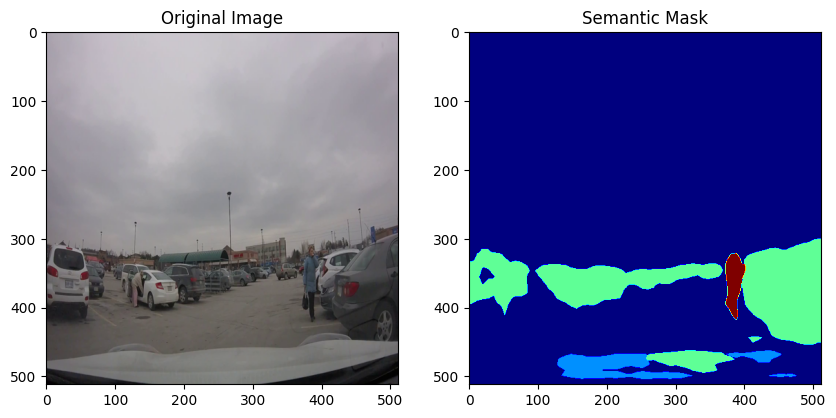

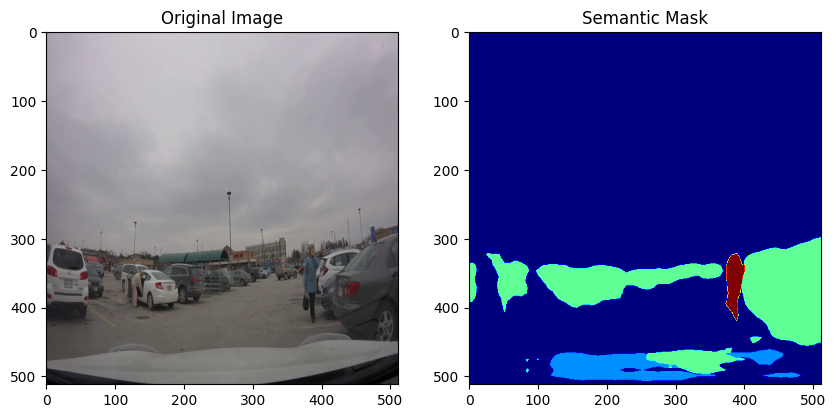

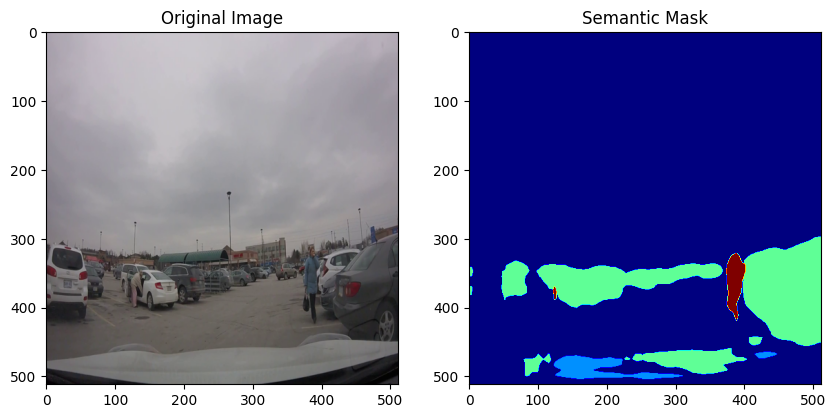

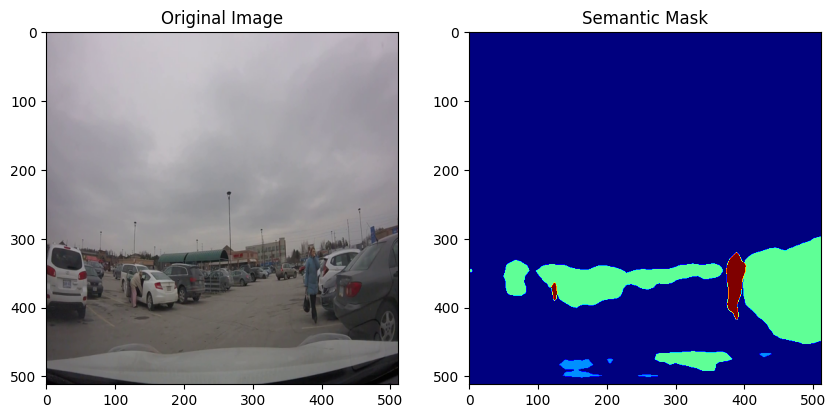

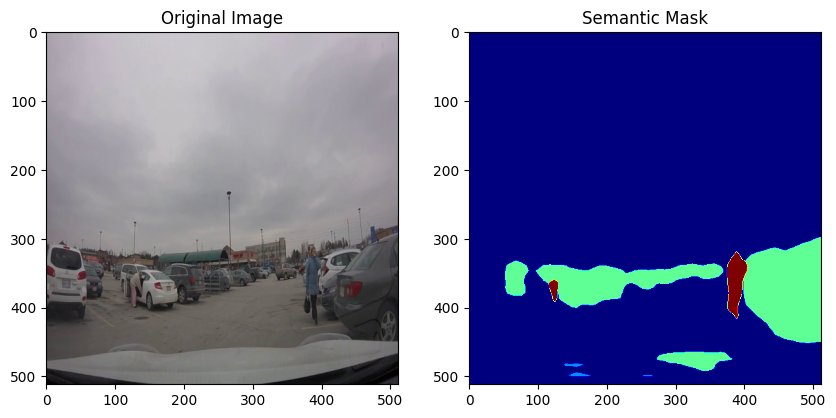

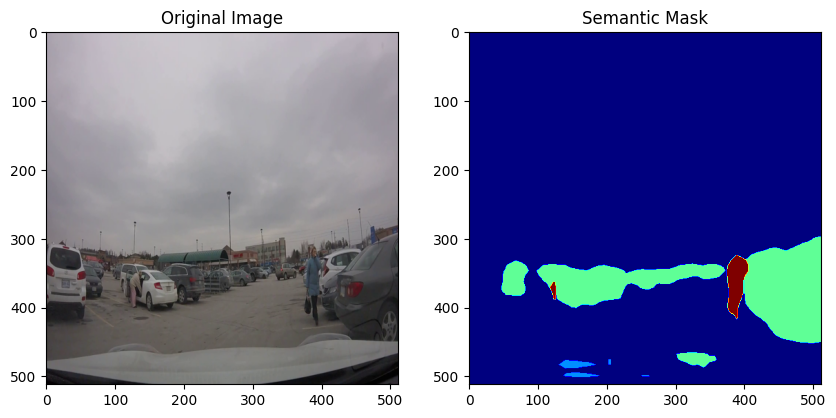

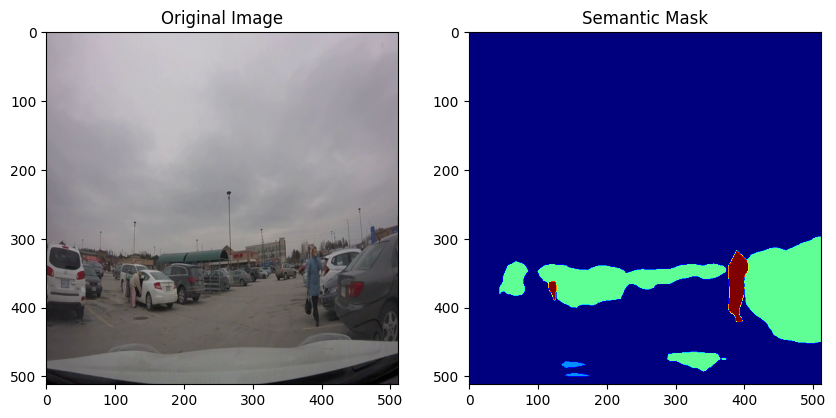

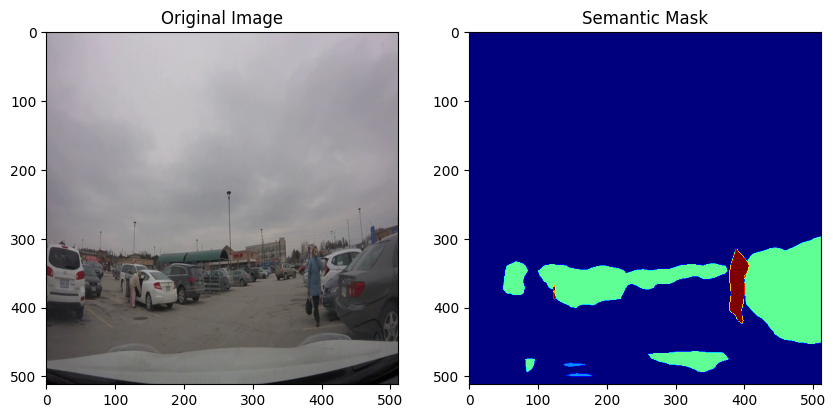

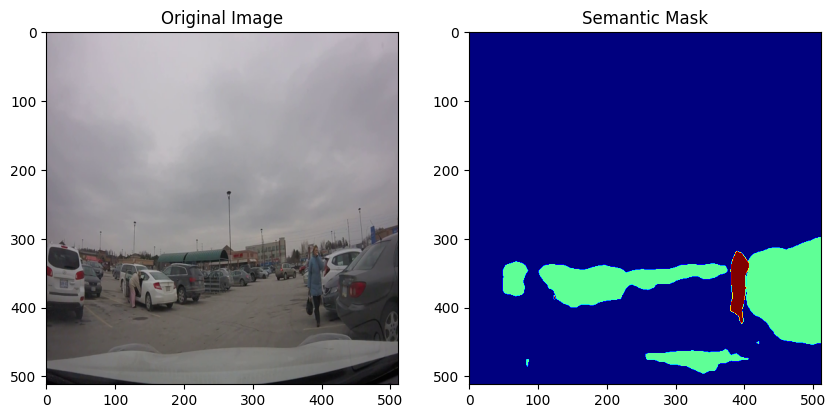

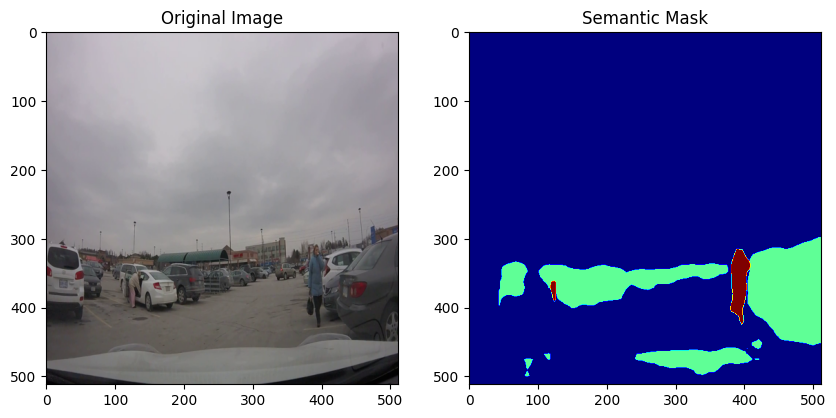

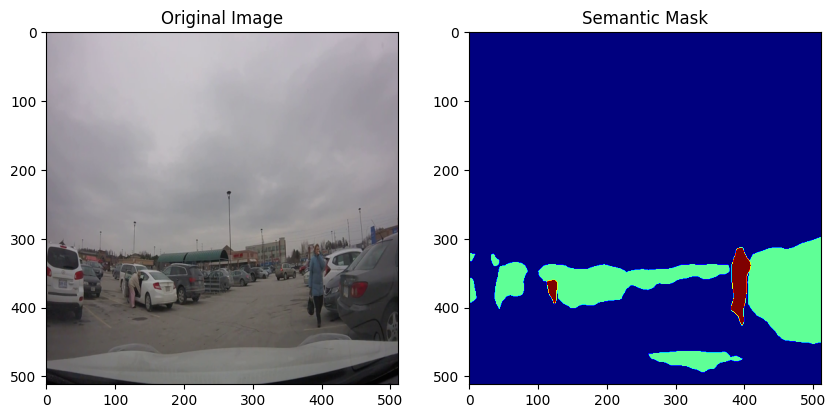

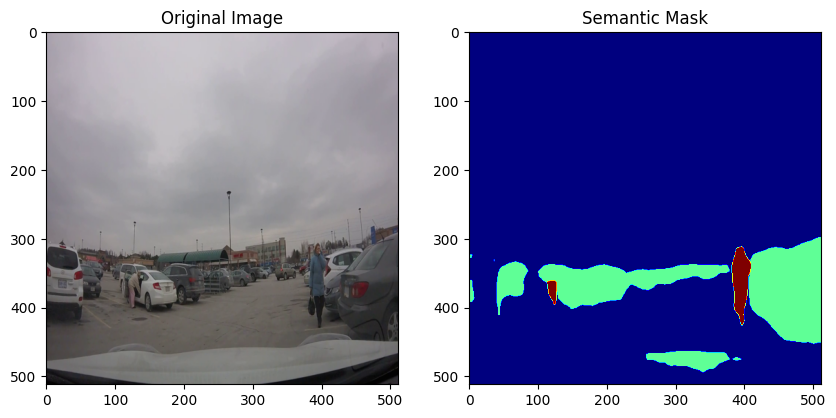

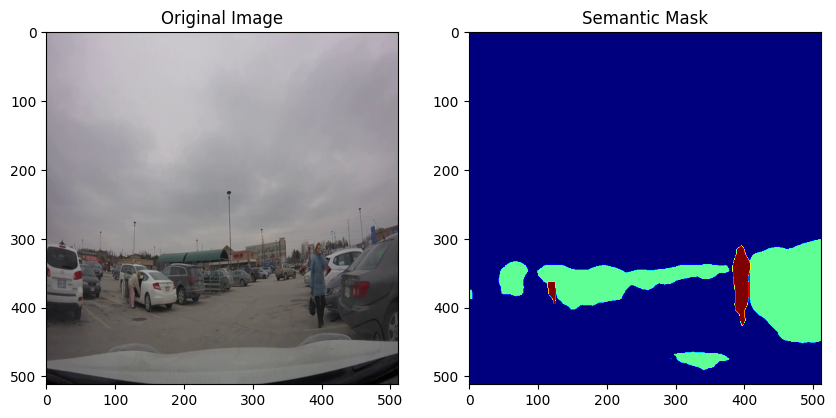

KeyboardInterrupt: 

<Figure size 1000x500 with 0 Axes>

In [17]:
# Itera attraverso il dizionario per processare le immagini
for seq in seq_train['image']:
    for image_path in seq:
        if os.path.exists(image_path):
            mask = get_semantic_mask(image_path, model, preprocess)
            visualize_mask(image_path, mask)
            # Qui puoi salvare la maschera se necessario, ad esempio:
            # mask_image_path = image_path.replace('.jpg', '_mask.png')
            # plt.imsave(mask_image_path, mask, cmap='jet')

In [ ]:
for seq in seq_train['image']:
    for image_path in seq:
        if os.path.exists(image_path):
            mask = get_semantic_mask(image_path, model, preprocess)
            mask_image_path = image_path.replace('.jpg', '_mask.png')
            plt.imsave(mask_image_path, mask, cmap='jet')